<a href="https://colab.research.google.com/github/fardir/mlt-submission-1/blob/master/MLT_Proyek_Submission_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

 <h1><strong>Analisis Prediktif: Prediksi Kemungkinan Kematian Akibat Gagal Jantung.</strong></h1>

| |
| :-: |
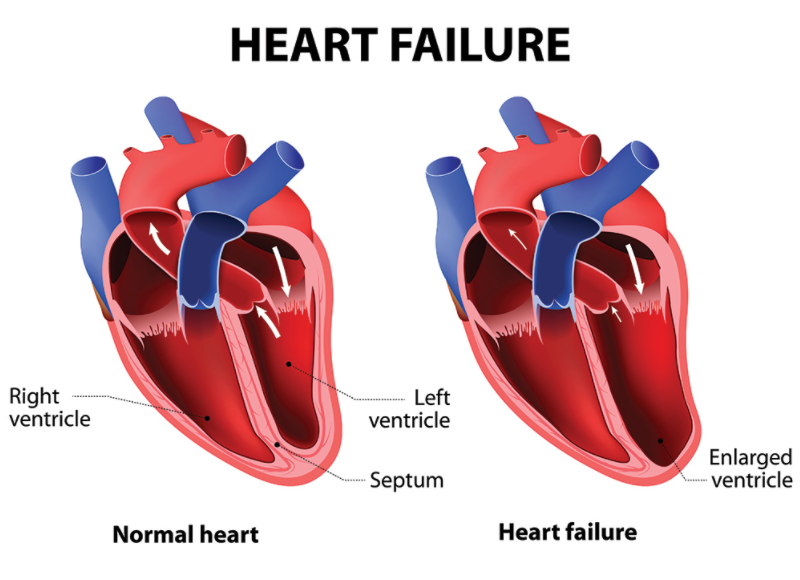

 # Pendahuluan

Proyek ini membahas mengenai topik `kesehatan` yang bertujuan untuk memprediksi kemungkinan kematian akibat gagal jantung pada pasien dengan penyakit kardiovaskular. Proyek ini dibuat untuk proyek Submission 1 - Machine Learning Terapan Dicoding. Untuk memudahkan navigasi di halaman, silahkan gunakan menu `Table of Contents` di kiri atas halaman.

# 1. Mengimpor modul Python yang dibutuhkan

In [ ]:
#@title Memasang modul plotly & scikit-learn terbaru
!pip install -q -U plotly
!pip install -q -U scikit-learn

In [2]:
# Untuk pengolahan data
import pandas as pd
from sklearn.utils import resample
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Untuk visualisasi data
import missingno as msno
import plotly.express as px

# Untuk pembuatan model
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Untuk evaluasi model
from sklearn.metrics import confusion_matrix, classification_report

# 2. Pemahaman Data *(Data Understanding)*

| |
|:-:|
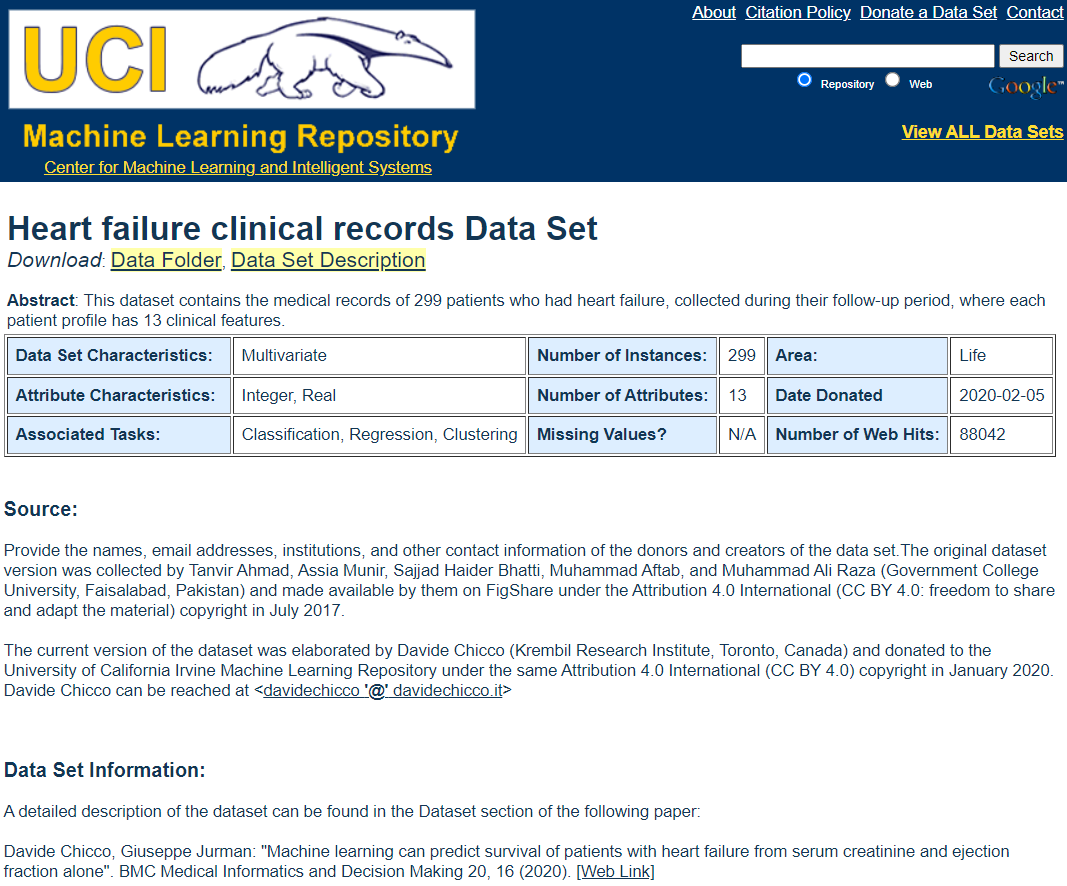


Informasi Dataset:

| Jenis | Keterangan |
|:-----:|:-----------|
| Sumber | [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Heart+failure+clinical+records) |
| Lisensi | CC BY 4.0: freedom to share and adapt the material |
| Kategori | Kesehatan, Kesehatan Masyarakat, Kondisi Jantung |
| Jenis dan Ukuran berkas | CSV (12.24 kB) |

## 2.1 Memuat Data dalam DataFrame menggunakan Pandas

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv')

In [4]:
df.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## 2.2 Keterangan kolom pada dataset

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [6]:
df.isna().sum()

age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [7]:
df.describe()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


## 2.3 Visualisasi Data

In [8]:
# Fungsi untuk plot distribusi data pada suatu kolom
def plot_num_distribution(column:str, title:str):
  figures = px.histogram(data_frame=df,
                        x=column,
                        color='DEATH_EVENT',
                        template='plotly_white',
                        marginal='box',
                        nbins=200,
                        color_discrete_sequence=["#FF7171","#9FD8DF"],
                        barmode='stack',
                        histfunc='count')

  figures.update_layout(font_family='Open Sans',
                        title=dict(text=title,
                                  x=0.47,
                                  font=dict(color="#333",size=20)),
                        hoverlabel=dict(bgcolor='white'))

  figures.show()

In [9]:
def plot_cat_distribution(column:str, names:list, title:str):
  data = pd.DataFrame(df[column].value_counts())
  figures = px.pie(data_frame=data,
                   values=column,
                   names=names,
                   hole=0.4,
                   color_discrete_sequence=["#FF7171","#9FD8DF"],
                   labels={'label':column, column:'No. of samples'})
  
  figures.update_layout(font_family='Open Sans',
                        title=dict(text=title,
                                   x=0.49,
                                   y=0.95,
                                   font=dict(color="#333", size=20)),
                        hoverlabel=dict(bgcolor='white'))
  
  figures.update_traces(textposition='outside', textinfo='percent+label')

  figures.show()

### 2.3.1 Visualisasi data yang kosong *(Missing values)*

In [10]:
# Melakukan visualisasi data yang kosong
sorted_null = msno.nullity_sort(df, sort='descending') 
figures = msno.matrix(sorted_null, color=(1, 0.43, 0.43))

### 2.3.2 Distribusi data pada kolom dengan fitur numerik (age, creatinine_phosphokinase,	ejection_fraction,	platelets, serum_creatinine, serum_sodium, dan time)

In [11]:
# Melakukan visualisasi data pada setiap kolom dengan fitur numerik
num_features = ['age', 'creatinine_phosphokinase',	'ejection_fraction',	'platelets', 'serum_creatinine', 'serum_sodium', 'time']

for column in num_features:
  plot_num_distribution(column=column, title=f"Distribusi fitur numerik pada kolom {column}")

### 2.3.3 Distribusi kelas pada kolom dengan fitur kategori (anaemia, diabetes, high_blood_pressure, sex, smoking, dan DEATH_EVENT)

In [12]:
# Melakukan visualisasi data pada setiap kolom dengan fitur kategori
cat_features = ['anaemia',
                'diabetes',
                'high_blood_pressure',
                'sex',
                'smoking', 
                'DEATH_EVENT']
                
names = [['False', 'True'], 
         ['False', 'True'], 
         ['False', 'True'], 
         ['Female', 'Male'], 
         ['False', 'True'], 
         ['Survived', 'Died']]


for column, names in zip(df[cat_features], names):
  plot_cat_distribution(column=column, names=names, title=f"Distribusi kelas pada kolom {column}")

### 2.3.4 Hubungan antar fitur kategori terhadap kelas

In [13]:
# Melakukan visualisasi data pada kolom DEATH_EVENT dengan anaemia
figures = px.pie(values=[len(df[(df['DEATH_EVENT']==0) & (df['anaemia']==1)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['anaemia']==1)]),
                         len(df[(df['DEATH_EVENT']==0) & (df['anaemia']==0)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['anaemia']==0)])],
                 hole=0.4,
                 color_discrete_sequence=["#FF7171","#9FD8DF"],
                 names=["Anaemia - Survived",
                        "Anaemia - Died", 
                        "No Anaemia -  Survived", 
                        "No Anaemia - Died"])
  
figures.update_layout(font_family='Open Sans',
                      title=dict(text='anaemia vs death_event',
                                 x=0.49,
                                 y=0.95,
                                 font=dict(color="#333", size=20)),
                      hoverlabel=dict(bgcolor='white'))
  
figures.update_traces(textposition='outside', textinfo='percent+label')

figures.show()

In [14]:
# Melakukan visualisasi data pada kolom DEATH_EVENT dengan diabetes
figures = px.pie(values=[len(df[(df['DEATH_EVENT']==0) & (df['diabetes']==1)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['diabetes']==1)]),
                         len(df[(df['DEATH_EVENT']==0) & (df['diabetes']==0)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['diabetes']==0)])],
                 hole=0.4,
                 color_discrete_sequence=["#FF7171","#9FD8DF"],
                 names=["Diabetes - Survived",
                        "Diabetes - Died", 
                        "No Diabetes -  Survived", 
                        "No Diabetes - Died"])
  
figures.update_layout(font_family='Open Sans',
                      title=dict(text='diabetes vs death_event',
                                 x=0.49,
                                 y=0.95,
                                 font=dict(color="#333", size=20)),
                      hoverlabel=dict(bgcolor='white'))
  
figures.update_traces(textposition='outside', textinfo='percent+label')

figures.show()

In [15]:
# Melakukan visualisasi data pada kolom DEATH_EVENT dengan high_blood_pressure
figures = px.pie(values=[len(df[(df['DEATH_EVENT']==0) & (df['high_blood_pressure']==1)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['high_blood_pressure']==1)]),
                         len(df[(df['DEATH_EVENT']==0) & (df['high_blood_pressure']==0)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['high_blood_pressure']==0)])],
                 hole=0.4,
                 color_discrete_sequence=["#FF7171","#9FD8DF"],
                 names=["HBP - Survived",
                        "HBP - Died", 
                        "No HBP -  Survived", 
                        "No HBP - Died"])
  
figures.update_layout(font_family='Open Sans',
                      title=dict(text='high_blood_pressure vs death_event',
                                 x=0.49,
                                 y=0.95,
                                 font=dict(color="#333", size=20)),
                      hoverlabel=dict(bgcolor='white'))
  
figures.update_traces(textposition='outside', textinfo='percent+label')

figures.show()

In [16]:
# Melakukan visualisasi data pada kolom DEATH_EVENT dengan sex
figures = px.pie(values=[len(df[(df['DEATH_EVENT']==0) & (df['sex']==1)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['sex']==1)]),
                         len(df[(df['DEATH_EVENT']==0) & (df['sex']==0)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['sex']==0)])],
                 hole=0.4,
                 color_discrete_sequence=["#FF7171","#9FD8DF"],
                 names=["Male - Survived",
                        "Male - Died", 
                        "Female -  Survived", 
                        "Female - Died"])
  
figures.update_layout(font_family='Open Sans',
                      title=dict(text='sex vs death_event',
                                 x=0.49,
                                 y=0.95,
                                 font=dict(color="#333", size=20)),
                      hoverlabel=dict(bgcolor='white'))
  
figures.update_traces(textposition='outside', textinfo='percent+label')

figures.show()

In [17]:
# Melakukan visualisasi data pada kolom DEATH_EVENT dengan smoking
figures = px.pie(values=[len(df[(df['DEATH_EVENT']==0) & (df['smoking']==1)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['smoking']==1)]),
                         len(df[(df['DEATH_EVENT']==0) & (df['smoking']==0)]),
                         len(df[(df['DEATH_EVENT']==1) & (df['smoking']==0)])],
                 hole=0.4,
                 color_discrete_sequence=["#FF7171","#9FD8DF"],
                 names=["Smoking - Survived",
                        "Smoking - Died", 
                        "No Smoking -  Survived", 
                        "No Smoking - Died"])
  
figures.update_layout(font_family='Open Sans',
                      title=dict(text='smoking vs death_event',
                                 x=0.49,
                                 y=0.95,
                                 font=dict(color="#333", size=20)),
                      hoverlabel=dict(bgcolor='white'))
  
figures.update_traces(textposition='outside', textinfo='percent+label')

figures.show()

### 2.3.5 Korelasi data antar kolom dengan fitur numerik

In [18]:
# Visualisasi matrix dari korelasi data
figures = px.scatter_matrix(data_frame=df, 
                            dimensions=df.drop(cat_features,axis=1),
                            template='plotly_white',
                            color="DEATH_EVENT",
                            symbol="DEATH_EVENT",
                            color_discrete_sequence=["#FF7171","#9FD8DF"],
                            color_continuous_scale=["#FF7171","#9FD8DF"],
                            height=1500)

figures.update_layout(font_family='Open Sans',
                      font_size=10,
                      title=dict(text='Korelasi data antar kolom (fitur numerik) - Visualisasi Matrix',
                                 x=0.49,
                                 y=0.98,
                                 font=dict(color="#333",size=20)),
                      hoverlabel=dict(bgcolor='white'),
                      coloraxis_showscale=False)

figures.update_traces(diagonal_visible=False)

figures.show()

In [19]:
# Mempersiapkan dataframe korelasi data antar kolom
correlations_data=df.drop('DEATH_EVENT',axis=1).corr()
correlations_data

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
age,1.000000,0.088006,-0.081584,-0.101012,0.060098,0.093289,-0.052354,0.159187,-0.045966,0.065430,0.018668,-0.224068
anaemia,0.088006,1.000000,-0.190741,-0.012729,0.031557,0.038182,-0.043786,0.052174,0.041882,-0.094769,-0.107290,-0.141414
creatinine_phosphokinase,-0.081584,-0.190741,1.000000,-0.009639,-0.044080,-0.070590,0.024463,-0.016408,0.059550,0.079791,0.002421,-0.009346
diabetes,-0.101012,-0.012729,-0.009639,1.000000,-0.004850,-0.012732,0.092193,-0.046975,-0.089551,-0.157730,-0.147173,0.033726
ejection_fraction,0.060098,0.031557,-0.044080,-0.004850,1.000000,0.024445,0.072177,-0.011302,0.175902,-0.148386,-0.067315,0.041729
high_blood_pressure,0.093289,0.038182,-0.070590,-0.012732,0.024445,1.000000,0.049963,-0.004935,0.037109,-0.104615,-0.055711,-0.196439
platelets,-0.052354,-0.043786,0.024463,0.092193,0.072177,0.049963,1.000000,-0.041198,0.062125,-0.125120,0.028234,0.010514
serum_creatinine,0.159187,0.052174,-0.016408,-0.046975,-0.011302,-0.004935,-0.041198,1.000000,-0.189095,0.006970,-0.027414,-0.149315
serum_sodium,-0.045966,0.041882,0.059550,-0.089551,0.175902,0.037109,0.062125,-0.189095,1.000000,-0.027566,0.004813,0.087640
sex,0.065430,-0.094769,0.079791,-0.157730,-0.148386,-0.104615,-0.125120,0.006970,-0.027566,1.000000,0.445892,-0.015608


In [20]:
# Visualisasi heatmap dari korelasi data
# semakin mendekati 1 semakin tinggi korelasi datanya
# semkain mendekati -1 semakin rendah korelasi datanya
figures = px.imshow(correlations_data,
                    color_continuous_scale=["#FF7171","#9FD8DF"])

figures.update_layout(font_family='Open Sans',
                      font_size=10,
                      title=dict(text='Korelasi data antar kolom - Visualisasi Heatmap',
                                 x=0.49,
                                 y=0.98,
                                 font=dict(color="#333",size=20)),
                      hoverlabel=dict(bgcolor='white'))

figures.show()

# 3. Persiapan Data *(Data Preparation)*

## 3.1 Mengatasi masalah data tidak seimbang dengan resample

In [21]:
# Menghitung label dari kolom DEATH_EVENT
df.DEATH_EVENT.value_counts()

0    203
1     96
Name: DEATH_EVENT, dtype: int64

In [22]:
# Memilih setiap labelnya
zero  = df[df['DEATH_EVENT']==0]
one = df[df['DEATH_EVENT']==1]

In [23]:
# Melakukan resample sehingga banyak data pada label = 1
# adalah 203
df_minority_resampled = resample(one, replace = True, n_samples = 203)

In [24]:
# # Memasukan datanya pada dataframe
df = pd.concat([zero, df_minority_resampled])

In [25]:
# Menghitung label dari kolom DEATH_EVENT
df.DEATH_EVENT.value_counts()

1    203
0    203
Name: DEATH_EVENT, dtype: int64

## 3.2 Melakukan pembagian data pada dataset dengan train_test_split

In [26]:
X = df.drop('DEATH_EVENT', axis=1).values
y = df['DEATH_EVENT'].values

In [27]:
# Melakukan pembagian data dengan train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [28]:
# Cek jumlah baris pada data train dan data test
print(X_train.shape)
print(X_test.shape)

(324, 12)
(82, 12)


## 3.3 Standarisasi nilai data pada fitur numerik dengan MinMaxScaler

In [29]:
# Inisialisasi fungsi MinMaxScaler
scaler = MinMaxScaler()

In [30]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [31]:
# Menampilkan sampel hasil standarisasi data
print(f"{X_train[0:3]} \n")
print(X_test[0:3])

[[0.58181818 0.         0.043506   1.         0.09090909 1.
  0.27748818 0.08988764 0.65714286 1.         1.         0.18996416]
 [0.27272727 0.         0.03993366 0.         0.46969697 1.
  0.36234695 0.04494382 0.77142857 0.         0.         0.2437276 ]
 [0.36363636 0.         0.07131921 1.         0.36363636 1.
  0.51630501 0.01123596 0.71428571 1.         1.         0.1218638 ]] 

[[0.18181818 0.         0.0691856  0.         0.5        1.
  0.2172619  0.18390805 0.5        0.         0.         0.19117647]
 [0.63636364 1.         0.05080419 0.         0.         0.
  0.08482143 0.05747126 0.7        1.         0.         0.00735294]
 [0.54545455 1.         0.0199132  0.         0.2        1.
  0.2485119  0.03448276 0.8        0.         0.         0.02573529]]


In [32]:
# Cek jumlah baris pada data train dan data test
print(X_train.shape)
print(X_test.shape)

(324, 12)
(82, 12)


# 4. Pembuatan Model

## 4.1 Model dengan Algoritma SVM

In [33]:
# Pembuatan model
svm_model = SVC(random_state=123)
svm_model.fit(X_train, y_train)

SVC(random_state=123)

In [34]:
# Pengujian model pada data test
y_pred = svm_model.predict(X_test)

In [35]:
# Hasil klasifikasi model SVM
svm_report = classification_report(y_test, y_pred, output_dict=True, target_names=['Survived',"Died"])
pd.DataFrame(svm_report).transpose()

,precision,recall,f1-score,support
Survived,0.775510,0.926829,0.844444,41.000000
Died,0.909091,0.731707,0.810811,41.000000
accuracy,0.829268,0.829268,0.829268,0.829268
macro avg,0.842301,0.829268,0.827628,82.000000
weighted avg,0.842301,0.829268,0.827628,82.000000


In [36]:
# Menyimpan hasil prediksi untuk confussion matrix
svm_cf = confusion_matrix(y_test, y_pred)

## 4.2 Model dengan Algoritma Random Forest

In [37]:
# Pembuatan model
rf_model = RandomForestClassifier(random_state=123)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=123)

In [38]:
# Pengujian model pada data test
y_pred = rf_model.predict(X_test)

In [39]:
# Hasil klasifikasi model Random Forest
rf_report = classification_report(y_test, y_pred, output_dict=True, target_names=['Survived', 'Died'])
pd.DataFrame(rf_report).transpose()

,precision,recall,f1-score,support
Survived,1.000000,0.95122,0.975000,41.00000
Died,0.953488,1.00000,0.976190,41.00000
accuracy,0.975610,0.97561,0.975610,0.97561
macro avg,0.976744,0.97561,0.975595,82.00000
weighted avg,0.976744,0.97561,0.975595,82.00000


In [40]:
# Menyimpan hasil prediksi untuk confussion matrix
rf_cf = confusion_matrix(y_test, y_pred)

# 5. Evaluasi Model

## 5.1 Perbandingan metriks antara model SVM dengan model Random Forest

In [41]:
# Memasukkan hasil laporan klasifikasi model pada dataframe
metrics = pd.DataFrame({'accuracy' : [svm_report['accuracy'], rf_report['accuracy']],
                        'f1-score_0' : [svm_report['Survived']['f1-score'], rf_report['Survived']['f1-score']],
                        'precision_0' : [svm_report['Survived']['precision'], rf_report['Survived']['precision']],
                        'recall_0' : [svm_report['Survived']['recall'], rf_report['Survived']['recall']],
                        'f1-score_1' : [svm_report['Died']['f1-score'], rf_report['Died']['f1-score']],
                        'precision_1' : [svm_report['Died']['precision'], rf_report['Died']['precision']],
                        'recall_1' : [svm_report['Died']['recall'], rf_report['Died']['recall']]},
                        index=['Model dengan SVM','Model dengan Random Forest'])
multiheader = [('','accuracy'),
               ('Survived', 'f1-score'),
               ('Survived', 'precision'),
               ('Survived', 'recall'),
               ('Died', 'f1-score'),
               ('Died', 'precision'),
               ('Died', 'recall')]
metrics.columns = pd.MultiIndex.from_tuples(multiheader)
# Menampilkan dataframe
metrics

Survived  ...      Died          
                            accuracy  f1-score  ... precision    recall
Model dengan SVM            0.829268  0.844444  ...  0.909091  0.731707
Model dengan Random Forest  0.975610  0.975000  ...  0.953488  1.000000

[2 rows x 7 columns]

## 5.2 Confusion Matrix

In [42]:
# Visualisasi hasil prediksi model SVM
figures = px.imshow(svm_cf,
                    labels=dict(x="True", y="Predict", color="Terprediksi"),
                    x=['Survived', 'Died'],
                    y=['Survived', 'Died'],
                    color_continuous_scale=["#FF7171","#9FD8DF"])

figures.update_layout(font_family='Open Sans',
                      font_size=10,
                      title=dict(text='Confussion Matrix - Model SVM',
                                 x=0.49,
                                 y=0.98,
                                 font=dict(color="#333",size=20)),
                      hoverlabel=dict(bgcolor='white'),
                      coloraxis_showscale=False)
figures.show()

In [43]:
# Visualisasi hasil prediksi model Random Forest
figures = px.imshow(rf_cf,
                    labels=dict(x="True", y="Predict", color="Terprediksi"),
                    x=['Survived', 'Died'],
                    y=['Survived', 'Died'],
                    color_continuous_scale=["#FF7171","#9FD8DF"])

figures.update_layout(font_family='Open Sans',
                      font_size=10,
                      title=dict(text='Confussion Matrix - Model Random Forest',
                                 x=0.49,
                                 y=0.98,
                                 font=dict(color="#333",size=20)),
                      hoverlabel=dict(bgcolor='white'),
                      coloraxis_showscale=False)
figures.show()

# Penutupan

Model untuk memprediksi kemungkinan kematian akibat gagal jantung pada pasien dengan penyakit kardiovaskular telah selesai dibuat dan model ini dapat digunakan untuk memprediksi data yang sebenarnya. Model diharapkan dapat digunakan untuk membantu rumah sakit dalam menilai tingkat keparahan pasien dengan penyakit kardiovaskular. Namun, beberapa pengembangan lain masih dapat dilakukan agar dapat membuat model dengan akurasi yang lebih tinggi seperti mencoba menggunakan algoritma lainnya seperti K-Nearest Neighbors, Gradient Boosting, dan pendekatan *deep learning*. Selain itu, penerapan *hyperparameter tuning* juga dapat menjadi alternatif.

### Referensi
* Dokumentasi Scikit-learn: https://scikit-learn.org/stable/
* Dokumentasi Plotly: https://plotly.com/python/
* Lainnya:
  * https://www.kaggle.com/sanchitakarmakar/heart-failure-prediction-visualization
  * https://www.kaggle.com/nayansakhiya/heart-fail-analysis-and-quick-prediction
  * https://www.kaggle.com/isaienkov/data-visualization-modeling-82-acc-75-f1

